In [1]:
import os
import sys

python_working_dir = !pwd
package_path = '/'.join(python_working_dir[0].split('/')[:-1])
print(package_path)

sys.path.append(package_path)

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from fraud_prevention.features import creditcard
from fraud_prevention.features import cc_transaction_features

/Users/luis.sanchez/conekta/project


# Add synthetic data

Add synthetic data to the original dataset:
- Credit card number
- Geologations
- Grouping transactions to compose credit card historic records

In [2]:
creditcard.process()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284807/284807 [00:26<00:00, 10788.70it/s]


# Compute historical features

- Time since previous transaction
- Delta distance from the current geolocation transaction and the previous geolocation transaction

In [3]:
cc_transaction_features.process()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57015/57015 [04:16<00:00, 222.15it/s]


In [4]:
data = cc_transaction_features.get()

# Features Explanation 

In [29]:
credit_card_number = pd.DataFrame({
    "transactions_count": data['credit_card_number'].value_counts(),
    "fraud_counts": data.query('Class == 1')['credit_card_number'].value_counts()
}).query(
    '(transactions_count == 5) & '
    '(fraud_counts > 0)'
).sort_values('transactions_count').index[-1]

In [30]:
data[
    data['credit_card_number'] == credit_card_number
].sort_values('timestamp').set_index('credit_card_number')[[
    'timestamp',
    'time_prev_transaction',
    'Class'
]]

,timestamp,time_prev_transaction,Class
credit_card_number,,,
676175042594,41224.0,NaN,0
676175042594,41284.0,60.0,0
676175042594,41344.0,60.0,0
676175042594,41344.5,0.5,1
676175042594,41374.5,30.0,0


In [31]:
data[
    data['credit_card_number'] == credit_card_number
].sort_values('timestamp').set_index('credit_card_number')[[
    'latitude',
    'longitude',
    'km_dist_prev_transaction',
    'Class'
]]

,latitude,longitude,km_dist_prev_transaction,Class
credit_card_number,,,,
676175042594,45.44868,-73.81669,NaN,0
676175042594,34.21639,-119.03760,4007.859268,0
676175042594,25.87972,-97.50417,2266.828335,0
676175042594,43.86682,-79.26630,2588.102676,1
676175042594,42.58342,-71.80230,622.691264,0


# Analysis

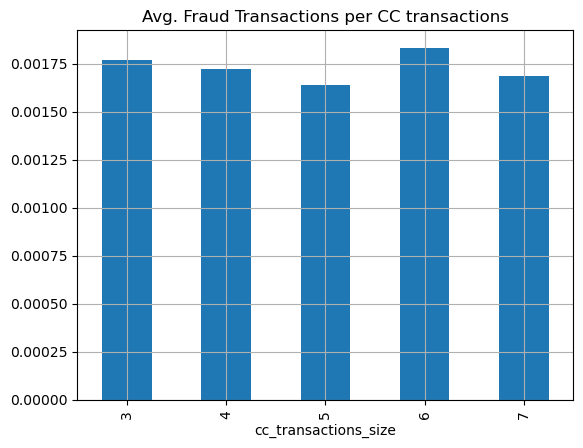

In [22]:
pd.DataFrame({
    "cc_transactions_size": data.groupby(
        'credit_card_number'
    ).size(),
     "fraud_avg": data.groupby(
        'credit_card_number'
    )['Class'].mean()
}).groupby(
    'cc_transactions_size'
)['fraud_avg'].mean().sort_index().plot(
    title='Avg. Fraud Transactions per CC transactions',
    kind='bar')

ax.set_ylabel('% Fraud Avg.')
ax.set_xlabel('# transactions');

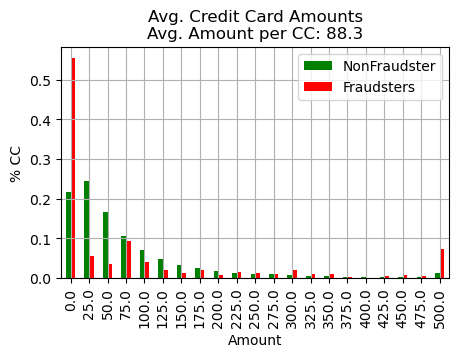

In [23]:
amount_means = data.groupby(
    'credit_card_number'
)['Amount'].mean().mean()

class_and_color = zip([0, 1], ['green', 'red'])
amounts = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot = data[
        data['Class'] == cls
    ].groupby(
        'credit_card_number'
    )['Amount'].mean()
    data_plot.name = f'{cls_name} Amount Avg'

    amounts[cls_name] = data_plot.apply(
        lambda x: x - (x % 25)
    ).clip(0, 500).value_counts()

amounts = pd.DataFrame(amounts)
amounts = amounts / amounts.sum()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
amounts.plot(
    kind='bar', ax=ax, legend=True, color=['green', 'red'])
ax.set_ylabel('% CC')
ax.set_xlabel('Amount')
ax.set_title(
    'Avg. Credit Card Amounts\n'
    f'Avg. Amount per CC: {round(amount_means, 2)}');

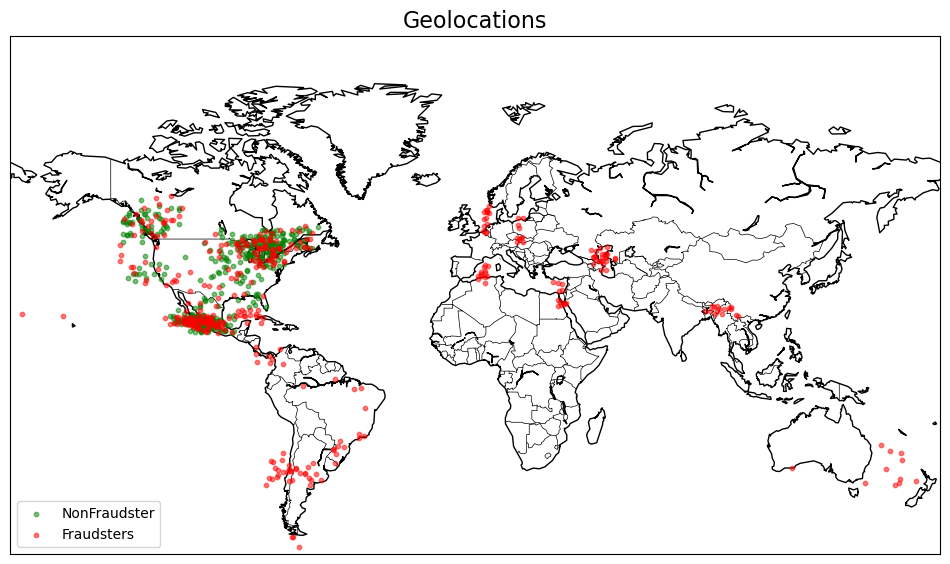

In [24]:
import random

# Create a new figure
plt.figure(figsize=(12, 8))

# Create a basemap instance for the whole world
m = Basemap(
    projection='mill', 
    llcrnrlat=-60, 
    urcrnrlat=90,
    llcrnrlon=-180, 
    urcrnrlon=180, 
    resolution='c')

# Draw coastlines and country boundaries
m.drawcoastlines()
m.drawcountries()

for cls, data_sample in data.groupby('Class'):
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    if len(data_sample) > 400:
        data_sample = data_sample.sample(400)

    lats = data_sample['latitude'].astype(float).apply(
        lambda x: x * (
            1 + (.01 * random.choice(list(range(0, 15))))
        )
    ).astype(float).tolist()

    lons = data_sample['longitude'].astype(float).apply(
        lambda x: x * (
            1 + (.01 * random.choice(list(range(0, 15))))
        )
    ).astype(float).tolist()
    
    x, y = m(lons, lats)
    data_sample['x'] = x
    data_sample['y'] = y
    
    if cls == 1:
        color = 'red'
        alpha = .5
    else:
        color = 'green'
        alpha = .5

    m.scatter(
        x, y, color=color, marker='o', s=10, zorder=5, label=cls_name, alpha=alpha)

# Add a title and legend
plt.title("Geolocations", fontsize=16)
plt.legend(loc='lower left')

# Show the plot
plt.show()

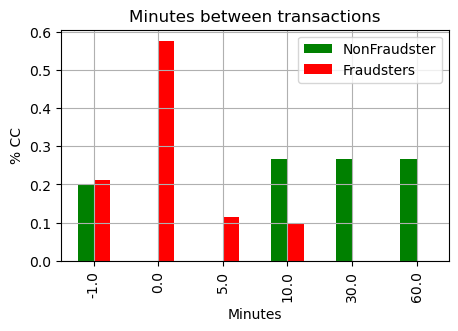

In [25]:
class_and_color = zip([0, 1], ['green', 'red'])
prev_time = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot = data[
        data['Class'] == cls
    ]['time_prev_transaction'].apply(
        lambda x: x - (x % 5)
    ).fillna(-1).value_counts()
    data_plot.name = f'{cls_name} Time prev. transaction'

    prev_time[cls_name] = data_plot

prev_times = pd.DataFrame(prev_time)
data_plot = (prev_times / prev_times.sum())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
data_plot.plot(
    kind='bar', ax=ax, legend=True, color=['green', 'red'])
ax.set_ylabel('% CC')
ax.set_xlabel('Minutes')
ax.set_title(
    'Minutes between transactions');

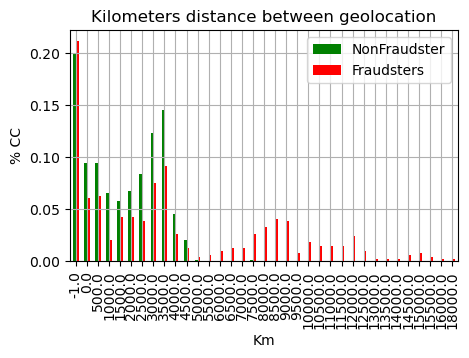

In [26]:
class_and_color = zip([0, 1], ['green', 'red'])
prev_time = {}
for (cls, color) in class_and_color:
    cls_name = 'Fraudsters' if cls == 1 else 'NonFraudster'
    data_plot = data[
        data['Class'] == cls
    ]['km_dist_prev_transaction'].apply(
        lambda x: x - (x % 500)
    ).fillna(-1).value_counts()
    data_plot.name = f'{cls_name} Time prev. transaction'

    prev_time[cls_name] = data_plot

prev_times = pd.DataFrame(prev_time)
data_plot = (prev_times / prev_times.sum())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
data_plot.plot(
    kind='bar', ax=ax, legend=True, color=['green', 'red'])

ax.set_ylabel('% CC')
ax.set_xlabel('Km')
ax.set_title(
    'Kilometers distance between geolocation');